# Pre-processing

Import the JAFFE dataset and extract dominant labels. The image name consists of two parts, the name of model and the dominanat label, eg: KM is the name of model with neutral as dominant feature

In [1]:
from PIL import Image
import glob
from matplotlib import pyplot as plt
raw_images = []
raw_labels = []
for filename in glob.glob('jaffe\images/*.tiff'):
    raw_labels.append(filename[16:18])
    im = Image.open(filename)
    raw_images.append(im)
#make sure images are uploaded correctly
print(len(raw_images))
imgplot = plt.imshow(raw_images[0])
#plot the number of each label
num_neutral = raw_labels.count('NE')
num_happy = raw_labels.count('HA')
num_sad = raw_labels.count('SA')
num_surprised = raw_labels.count('SU')
num_angry = raw_labels.count('AN')
num_disgust = raw_labels.count('DI')
num_fear = raw_labels.count('FE')
print("The number of labels are as follows")
print("Neutral : {}  Happy : {}  Sad : {}  Surprised : {}  Angry : {}  Disgust : {}  Fear : {}"\
      .format(num_neutral, num_happy, num_sad, num_surprised, num_angry, num_disgust, num_fear))

213
The number of labels are as follows
Neutral : 30  Happy : 31  Sad : 31  Surprised : 30  Angry : 30  Disgust : 29  Fear : 32


### Augmentation

Add random gaussian noise, random rotation and random skewness to the images. Translation wont be used in this project since the image will be cropped to just the face.

In [2]:
import random
import skimage as sk
from skimage import transform as tf
from skimage import img_as_ubyte
from scipy import ndarray
from skimage import util
import numpy as np

def random_noise(image):
    image = np.array(image)
    im = sk.util.random_noise(image)
    im = img_as_ubyte(im)
    return im

def random_rotation(image):
    image = np.array(image)
    random_degree = random.uniform(-15, 15)
    im = (sk.transform.rotate(image, random_degree))
    im = img_as_ubyte(im)
    return im

def random_skew(image):
    shear = random.uniform(-0.2, 0.2)
    afine_tf = tf.AffineTransform(shear = shear)
    im = tf.warp(image, inverse_map=afine_tf)
    im = img_as_ubyte(im)
    return im


C:\Users\peter\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


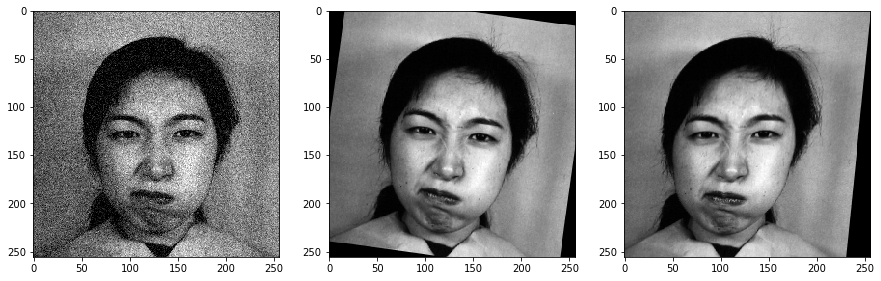

In [3]:
plt.figure(1, figsize=(15, 15))
plt.subplot(1,3,1)
plt.imshow(random_noise(raw_images[0]), cmap = plt.cm.gray)
plt.subplot(1,3,2)
plt.imshow(random_rotation(raw_images[0]), cmap = plt.cm.gray)
plt.subplot(1,3,3)
plt.imshow(random_skew(raw_images[0]), cmap = plt.cm.gray)

Apply the transformation functions to the dataset to obtain a dataset of 1000 images

In [4]:
augmented_images = raw_images
augmented_raw_labels = raw_labels
size = len(raw_images)
desired_size = 3000
for generated_number in range(desired_size - size):
    #pick a random image from raw images
    r = random.randint(0, size)
    im = raw_images[r]
    #add the label ot augmenetd labels
    augmented_raw_labels.append(raw_labels[r])
    #pick a random trasnformation
    trans = random.randint(1,3)
    if(trans == 1):
        #apply random gaussian noise
        augmented_images.append(random_noise(im))
    elif(trans == 2):
        #apply random rotation
        augmented_images.append(random_rotation(im))
    else:
        #apply random skew
        augmented_images.append(random_skew(im))
print(len(augmented_raw_labels))

C:\Users\peter\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


3000


In [5]:
num_neutral = augmented_raw_labels.count('NE')
num_happy = augmented_raw_labels.count('HA')
num_sad = augmented_raw_labels.count('SA')
num_surprised = augmented_raw_labels.count('SU')
num_angry = augmented_raw_labels.count('AN')
num_disgust = augmented_raw_labels.count('DI')
num_fear = augmented_raw_labels.count('FE')
print("The number of augmented_labels are as follows")
print("Neutral : {}  Happy : {}  Sad : {}  Surprised : {}  Angry : {}  Disgust : {}  Fear : {}"\
      .format(num_neutral, num_happy, num_sad, num_surprised, num_angry, num_disgust, num_fear))

The number of augmented_labels are as follows
Neutral : 426  Happy : 448  Sad : 429  Surprised : 423  Angry : 436  Disgust : 394  Fear : 444


### Encoding Labels
Transform the labels into a vector of seven numbers [Neutral Happy Sad Surprised Angry Disgust Fear] where an entry of 1 describes the label of the image

[0 1 0 0 0 0 0] descrbies a happy image

In [6]:

labels_names = ['Neutral', 'Happy', 'Sad', 'Surprised', 'Angry', 'Disgust', 'Fear']
augmented_labels = np.zeros((len(augmented_images), len(labels_names)))
for i, value in enumerate(augmented_raw_labels):
    if(value == 'NE'):
        augmented_labels[i][0] = 1
    elif(value == 'HA'):
        augmented_labels[i][1] = 1
    elif(value == 'SA'):
        augmented_labels[i][2] = 1
    elif(value == 'SU'):
        augmented_labels[i][3] = 1
    elif(value == 'AN'):
        augmented_labels[i][4] = 1
    elif(value == 'DI'): 
        augmented_labels[i][5] = 1
    elif(value == 'FE'):
        augmented_labels[i][6] = 1
    else:
        print('Inavalid Label')
print(len(augmented_labels))
print(augmented_labels[0])

3000
[0. 0. 0. 0. 1. 0. 0.]


### Face detection

Number of faces detected: 1


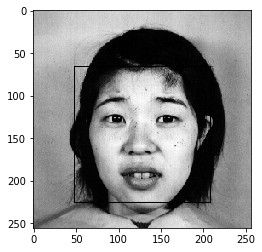

In [7]:
import cv2 
face_cascade = cv2.CascadeClassifier('D:\machine-learning-master\machine-learning-master\projects\Facial Expressions\Project\haarcascade_frontalface_alt.xml')
img = np.array(augmented_images[50])
faces = face_cascade.detectMultiScale(img)
print('Number of faces detected:', len(faces))
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,0),0)
plt.imshow(img, cmap = plt.cm.gray)


In [8]:
def face_detector(img):
    img = np.array(img)
    return face_cascade.detectMultiScale(img)

### Cropping
before cropping we want to remove images that have zero detected faces or more than one detected face. also remove images that have too small detected faces (some images have detected faces that are not actually faces and are too small regions)

In [9]:
import sys
num_bad_images = 0
cropped_images = []
for i,img in enumerate(augmented_images):
    if(i%10 == 0):
        print('\r{}/{}'.format(i, len(augmented_images)), end="", flush = True)
    faces = face_detector(img)
    if(len(faces) != 1):
        num_bad_images += 1
        augmented_labels = np.delete(augmented_labels, i, axis = 0)
    elif(faces[0][2] < 50 or faces[0][3] < 50):
            num_bad_images += 1
            augmented_labels = np.delete(augmented_labels, i, axis = 0)
    else:
        #crop the image
        x, y, w, h = faces[0]
        array_image = np.array(augmented_images[i])
        cropped_images.append(array_image[y:y+h, x:x+w])
#check if all bad images are removed
if((desired_size == (len(cropped_images) + num_bad_images)) and (desired_size == (len(augmented_labels) + num_bad_images))):
    print('\rall undetectable images removed, {} images remining'.format(len(cropped_images)))
else:
    print('\rot all undetectable images removed please restart kernel')


all undetectable images removed, 2996 images remining


[0. 0. 0. 1. 0. 0. 0.]


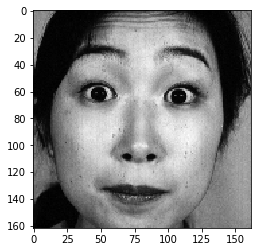

In [10]:
plt.imshow(cropped_images[20], cmap = plt.cm.gray)
print(augmented_labels[20])

In [11]:
#resize all images to largest cropped image size
from PIL import Image
X = [cropped_images[i].shape[0] for i in range(len(cropped_images))]
max_x = max(X)
Y = [cropped_images[i].shape[1] for i in range(len(cropped_images))]
max_y = max(Y)
resized_augmented_images = [Image.fromarray(cropped_images[i]).resize((max_x, max_y), Image.BILINEAR) \
                            for i in range(len(cropped_images))]
print("The final image dataset has a dimensions of {}".format(resized_augmented_images[0].size))

The final image dataset has a dimensions of (186, 186)


### Normalization

In [12]:
def normalize(img):
    img = np.array(img)
    img_min = np.min(img)
    img_max = np.max(img)
    img = (img - img_min) / float(img_max - img_min)
    return img

In [13]:
nomralized_augmented_images = [normalize(resized_augmented_images[i]) for i in range(len(resized_augmented_images))]
print(nomralized_augmented_images[0])

[[0.53811659 0.5426009  0.55156951 ... 0.51121076 0.51569507 0.51121076]
 [0.55605381 0.56502242 0.56950673 ... 0.50224215 0.51121076 0.51569507]
 [0.56950673 0.56053812 0.56053812 ... 0.46636771 0.52466368 0.53363229]
 ...
 [0.24663677 0.30941704 0.26457399 ... 0.53363229 0.5470852  0.55156951]
 [0.26008969 0.28251121 0.24663677 ... 0.52914798 0.5426009  0.56053812]
 [0.2735426  0.25560538 0.24663677 ... 0.51569507 0.53811659 0.57399103]]


### Train_Test Split

[0. 1. 0. 0. 0. 0. 0.]


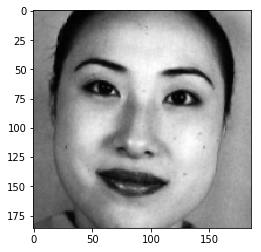

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(nomralized_augmented_images, augmented_labels, test_size = 0.2, random_state = 42)
plt.imshow(X_train[0], cmap = plt.cm.gray)
print(Y_train[0])

### Convert to 4D tensors

In [15]:
def convert_to_tensors(image_array):
    image_array = np.array(image_array)
    tensors = np.resize(image_array, (image_array.shape[0], image_array.shape[1], image_array.shape[2], 1))
    return tensors

In [16]:

X_train = convert_to_tensors(X_train)
X_test = convert_to_tensors(X_test)
print(X_train.shape)
print(X_test.shape)

(2396, 186, 186, 1)
(600, 186, 186, 1)


# Training

### Initialize  Hyperparameters Grid

In [45]:

parameters_grid = {
    'initial_n_filters' : [16, 32, 64],
    'kernel_size' : [2, 3, 4],
    'learning_rate' : list(np.linspace(0.0005, 0.005, 45)),
    'momentum' : list(np.linspace(0.7, 0.9, 10)),
}

### Creating Model

In [46]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import RMSprop
def create_model(parameters):
    model = Sequential()

    model.add(Conv2D(filters= parameters['initial_n_filters'], kernel_size = parameters['kernel_size'], 
                     strides=1,kernel_initializer = 'random_normal', padding='same', 
                        activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
    model.add(MaxPooling2D(pool_size=2, strides=2))

    model.add(Conv2D(filters= parameters['initial_n_filters']*2, kernel_size = parameters['kernel_size'], 
                     strides=1,kernel_initializer = 'random_normal', padding='same', activation='relu')) 
    model.add(MaxPooling2D(pool_size=2, strides=2))

    model.add(Conv2D(filters=random_parameters['initial_n_filters']*4, kernel_size = random_parameters['kernel_size'], 
                     strides=1,kernel_initializer = 'random_normal', padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2))

    model.add(Flatten())
    model.add(Dense(7, activation='softmax'))
    model.summary()
    return model

### Create optimizer

In [19]:
def create_RMSprop_optimizer(parameters):
    return RMSprop(lr = parameters['learning_rate'], rho = parameters['momentum'])

###  Compile and Train Model

In [60]:
import random
import time
from IPython.display import clear_output
from keras.callbacks import ModelCheckpoint, EarlyStopping, History

#select how many random hyperparameters selection iterations
n_iterations = 30
#initlaize global min_val_loss
global_min_val_loss = np.inf
for i in range(n_iterations):
    print('\r{}/{}'. format(i, n_iterations))
    #initilaize random hyperparameters
    random_parameters = {K: random.sample(V, 1)[0] for K, V in parameters_grid.items()}
    #create model with random hyperparameters
    model = create_model(random_parameters)
    opt = create_RMSprop_optimizer(random_parameters)
    #compile model
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
    #train model
    epochs = 40
    checkpointer = ModelCheckpoint(filepath='saved_models/model_weights.hdf5', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 8)
    history = model.fit(X_train, Y_train, 
              validation_split = 0.33,
              epochs=epochs, batch_size = 20, callbacks=[checkpointer, early_stopping], verbose=1)
    #compare current min validation loss with global min validation loss
    current_min_val_loss = np.min(history.history['val_loss'])
    if(current_min_val_loss < global_min_val_loss):
        global_min_val_loss = current_min_val_loss
        #save the best model so far
        model.save('saved_models/best_model.h5')
        print('saving new best model, val_loss = {}'.format(current_min_val_loss))




0/30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_163 (Conv2D)          (None, 186, 186, 16)      272       
_________________________________________________________________
max_pooling2d_163 (MaxPoolin (None, 93, 93, 16)        0         
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 93, 93, 32)        8224      
_________________________________________________________________
max_pooling2d_164 (MaxPoolin (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_165 (Conv2D)          (None, 46, 46, 64)        32832     
_________________________________________________________________
max_pooling2d_165 (MaxPoolin (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_55 (Flatten)         (None, 33856)             0         
_____

Train on 1605 samples, validate on 791 samples
Epoch 1/40
1605/1605 [==============================] - 7s 4ms/step - loss: 13.5755 - acc: 0.1489 - val_loss: 14.0193 - val_acc: 0.1302

Epoch 00001: val_loss improved from inf to 14.01928, saving model to saved_models/model_weights.hdf5
Epoch 2/40
1605/1605 [==============================] - 5s 3ms/step - loss: 13.7380 - acc: 0.1477 - val_loss: 14.0193 - val_acc: 0.1302

Epoch 00002: val_loss did not improve from 14.01928
Epoch 3/40
1605/1605 [==============================] - 5s 3ms/step - loss: 13.7380 - acc: 0.1477 - val_loss: 14.0193 - val_acc: 0.1302

Epoch 00003: val_loss did not improve from 14.01928
Epoch 4/40
1605/1605 [==============================] - 5s 3ms/step - loss: 13.7380 - acc: 0.1477 - val_loss: 14.0193 - val_acc: 0.1302

Epoch 00004: val_loss did not improve from 14.01928
Epoch 5/40
1605/1605 [==============================] - 5s 3ms/step - loss: 13.7380 - acc: 0.1477 - val_loss: 14.0193 - val_acc: 0.1302

Epoch 00005


Epoch 00009: val_loss did not improve from 13.67287
Epoch 00009: early stopping
5/30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_178 (Conv2D)          (None, 186, 186, 32)      160       
_________________________________________________________________
max_pooling2d_178 (MaxPoolin (None, 93, 93, 32)        0         
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 93, 93, 64)        8256      
_________________________________________________________________
max_pooling2d_179 (MaxPoolin (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 46, 46, 128)       32896     
_________________________________________________________________
max_pooling2d_180 (MaxPoolin (None, 23, 23, 128)       0         
________________________________________________________

1605/1605 [==============================] - 7s 4ms/step - loss: 0.0562 - acc: 0.9900 - val_loss: 0.3228 - val_acc: 0.9191

Epoch 00010: val_loss did not improve from 0.27481
Epoch 11/40
1605/1605 [==============================] - 7s 4ms/step - loss: 0.0884 - acc: 0.9857 - val_loss: 0.3486 - val_acc: 0.9178

Epoch 00011: val_loss did not improve from 0.27481
Epoch 12/40
1605/1605 [==============================] - 7s 4ms/step - loss: 0.0354 - acc: 0.9938 - val_loss: 0.3185 - val_acc: 0.9305

Epoch 00012: val_loss did not improve from 0.27481
Epoch 13/40
1605/1605 [==============================] - 7s 4ms/step - loss: 0.0301 - acc: 0.9931 - val_loss: 0.4228 - val_acc: 0.9191

Epoch 00013: val_loss did not improve from 0.27481
Epoch 14/40
1605/1605 [==============================] - 7s 4ms/step - loss: 0.0293 - acc: 0.9956 - val_loss: 0.5562 - val_acc: 0.9241

Epoch 00014: val_loss did not improve from 0.27481
Epoch 15/40
1605/1605 [==============================] - 7s 4ms/step - loss: 

1605/1605 [==============================] - 7s 4ms/step - loss: 0.1612 - acc: 0.9502 - val_loss: 0.6814 - val_acc: 0.8053

Epoch 00008: val_loss improved from 0.73735 to 0.68137, saving model to saved_models/model_weights.hdf5
Epoch 9/40
1605/1605 [==============================] - 7s 4ms/step - loss: 0.1003 - acc: 0.9701 - val_loss: 0.3495 - val_acc: 0.8925

Epoch 00009: val_loss improved from 0.68137 to 0.34952, saving model to saved_models/model_weights.hdf5
Epoch 10/40
1605/1605 [==============================] - 7s 4ms/step - loss: 0.0797 - acc: 0.9813 - val_loss: 0.2509 - val_acc: 0.9393

Epoch 00010: val_loss improved from 0.34952 to 0.25094, saving model to saved_models/model_weights.hdf5
Epoch 11/40
1605/1605 [==============================] - 7s 4ms/step - loss: 0.0557 - acc: 0.9894 - val_loss: 0.4876 - val_acc: 0.9001

Epoch 00011: val_loss did not improve from 0.25094
Epoch 12/40
1605/1605 [==============================] - 7s 4ms/step - loss: 0.0524 - acc: 0.9913 - val_lo

Train on 1605 samples, validate on 791 samples
Epoch 1/40
1605/1605 [==============================] - 4s 3ms/step - loss: 2.0279 - acc: 0.1452 - val_loss: 1.9565 - val_acc: 0.1568

Epoch 00001: val_loss improved from inf to 1.95649, saving model to saved_models/model_weights.hdf5
Epoch 2/40
1605/1605 [==============================] - 3s 2ms/step - loss: 1.9471 - acc: 0.1389 - val_loss: 1.9474 - val_acc: 0.1568

Epoch 00002: val_loss improved from 1.95649 to 1.94737, saving model to saved_models/model_weights.hdf5
Epoch 3/40
1605/1605 [==============================] - 3s 2ms/step - loss: 1.9459 - acc: 0.1352 - val_loss: 1.9471 - val_acc: 0.1568

Epoch 00003: val_loss improved from 1.94737 to 1.94708, saving model to saved_models/model_weights.hdf5
Epoch 4/40
1605/1605 [==============================] - 3s 2ms/step - loss: 1.9459 - acc: 0.1458 - val_loss: 1.9475 - val_acc: 0.1568

Epoch 00004: val_loss did not improve from 1.94708
Epoch 5/40
1605/1605 [==============================] 

Train on 1605 samples, validate on 791 samples
Epoch 1/40
1605/1605 [==============================] - 6s 4ms/step - loss: 2.0761 - acc: 0.1290 - val_loss: 1.9461 - val_acc: 0.1568

Epoch 00001: val_loss improved from inf to 1.94615, saving model to saved_models/model_weights.hdf5
Epoch 2/40
1605/1605 [==============================] - 4s 2ms/step - loss: 1.9480 - acc: 0.1302 - val_loss: 1.9461 - val_acc: 0.1568

Epoch 00002: val_loss improved from 1.94615 to 1.94613, saving model to saved_models/model_weights.hdf5
Epoch 3/40
1605/1605 [==============================] - 4s 2ms/step - loss: 1.9458 - acc: 0.1427 - val_loss: 1.9463 - val_acc: 0.1568

Epoch 00003: val_loss did not improve from 1.94613
Epoch 4/40
1605/1605 [==============================] - 4s 2ms/step - loss: 1.9456 - acc: 0.1483 - val_loss: 1.9471 - val_acc: 0.1302

Epoch 00004: val_loss did not improve from 1.94613
Epoch 5/40
1605/1605 [==============================] - 4s 2ms/step - loss: 1.9458 - acc: 0.1371 - val_loss

1605/1605 [==============================] - 5s 3ms/step - loss: 1.4017 - acc: 0.4773 - val_loss: 2.1538 - val_acc: 0.3755

Epoch 00003: val_loss did not improve from 1.74858
Epoch 4/40
1605/1605 [==============================] - 5s 3ms/step - loss: 0.7526 - acc: 0.7439 - val_loss: 0.8584 - val_acc: 0.7345

Epoch 00004: val_loss improved from 1.74858 to 0.85838, saving model to saved_models/model_weights.hdf5
Epoch 5/40
1605/1605 [==============================] - 5s 3ms/step - loss: 0.4267 - acc: 0.8754 - val_loss: 0.3735 - val_acc: 0.8736

Epoch 00005: val_loss improved from 0.85838 to 0.37352, saving model to saved_models/model_weights.hdf5
Epoch 6/40
1605/1605 [==============================] - 5s 3ms/step - loss: 0.2358 - acc: 0.9252 - val_loss: 0.2584 - val_acc: 0.9102

Epoch 00006: val_loss improved from 0.37352 to 0.25844, saving model to saved_models/model_weights.hdf5
Epoch 7/40
1605/1605 [==============================] - 5s 3ms/step - loss: 0.1898 - acc: 0.9445 - val_loss:

Epoch 2/40
1605/1605 [==============================] - 3s 2ms/step - loss: 1.9464 - acc: 0.1371 - val_loss: 1.9469 - val_acc: 0.1302

Epoch 00002: val_loss did not improve from 1.94634
Epoch 3/40
1605/1605 [==============================] - 3s 2ms/step - loss: 1.9669 - acc: 0.1333 - val_loss: 1.9479 - val_acc: 0.1302

Epoch 00003: val_loss did not improve from 1.94634
Epoch 4/40
1605/1605 [==============================] - 3s 2ms/step - loss: 1.9461 - acc: 0.1383 - val_loss: 1.9480 - val_acc: 0.1302

Epoch 00004: val_loss did not improve from 1.94634
Epoch 5/40
1605/1605 [==============================] - 3s 2ms/step - loss: 1.9460 - acc: 0.1321 - val_loss: 1.9479 - val_acc: 0.1365

Epoch 00005: val_loss did not improve from 1.94634
Epoch 6/40
1605/1605 [==============================] - 3s 2ms/step - loss: 1.9458 - acc: 0.1408 - val_loss: 1.9473 - val_acc: 0.1568

Epoch 00006: val_loss did not improve from 1.94634
Epoch 7/40
1605/1605 [==============================] - 3s 2ms/step - 

Train on 1605 samples, validate on 791 samples
Epoch 1/40
1605/1605 [==============================] - 10s 6ms/step - loss: 1.9038 - acc: 0.3358 - val_loss: 1.3398 - val_acc: 0.5171

Epoch 00001: val_loss improved from inf to 1.33979, saving model to saved_models/model_weights.hdf5
Epoch 2/40
1605/1605 [==============================] - 7s 5ms/step - loss: 0.7427 - acc: 0.7489 - val_loss: 0.5941 - val_acc: 0.8015

Epoch 00002: val_loss improved from 1.33979 to 0.59405, saving model to saved_models/model_weights.hdf5
Epoch 3/40
1605/1605 [==============================] - 7s 5ms/step - loss: 0.3305 - acc: 0.8997 - val_loss: 0.2524 - val_acc: 0.9064

Epoch 00003: val_loss improved from 0.59405 to 0.25243, saving model to saved_models/model_weights.hdf5
Epoch 4/40
1605/1605 [==============================] - 7s 5ms/step - loss: 0.1943 - acc: 0.9408 - val_loss: 0.1810 - val_acc: 0.9393

Epoch 00004: val_loss improved from 0.25243 to 0.18104, saving model to saved_models/model_weights.hdf5


1605/1605 [==============================] - 7s 5ms/step - loss: 13.8485 - acc: 0.1408 - val_loss: 13.8563 - val_acc: 0.1403

Epoch 00004: val_loss did not improve from 13.85626
Epoch 5/40
1605/1605 [==============================] - 7s 5ms/step - loss: 13.8485 - acc: 0.1408 - val_loss: 13.8563 - val_acc: 0.1403

Epoch 00005: val_loss did not improve from 13.85626
Epoch 6/40
1605/1605 [==============================] - 7s 5ms/step - loss: 13.8485 - acc: 0.1408 - val_loss: 13.8563 - val_acc: 0.1403

Epoch 00006: val_loss did not improve from 13.85626
Epoch 7/40
1605/1605 [==============================] - 7s 5ms/step - loss: 13.8485 - acc: 0.1408 - val_loss: 13.8563 - val_acc: 0.1403

Epoch 00007: val_loss did not improve from 13.85626
Epoch 8/40
1605/1605 [==============================] - 8s 5ms/step - loss: 13.8485 - acc: 0.1408 - val_loss: 13.8563 - val_acc: 0.1403

Epoch 00008: val_loss did not improve from 13.85626
Epoch 9/40
1605/1605 [==============================] - 7s 5ms/ste

Train on 1605 samples, validate on 791 samples
Epoch 1/40
1605/1605 [==============================] - 7s 4ms/step - loss: 2.0197 - acc: 0.1651 - val_loss: 2.1504 - val_acc: 0.1378

Epoch 00001: val_loss improved from inf to 2.15036, saving model to saved_models/model_weights.hdf5
Epoch 2/40
1605/1605 [==============================] - 4s 2ms/step - loss: 1.3516 - acc: 0.4897 - val_loss: 1.0536 - val_acc: 0.6068

Epoch 00002: val_loss improved from 2.15036 to 1.05357, saving model to saved_models/model_weights.hdf5
Epoch 3/40
1605/1605 [==============================] - 4s 2ms/step - loss: 0.7295 - acc: 0.7589 - val_loss: 0.4728 - val_acc: 0.8331

Epoch 00003: val_loss improved from 1.05357 to 0.47276, saving model to saved_models/model_weights.hdf5
Epoch 4/40
1605/1605 [==============================] - 4s 2ms/step - loss: 0.3769 - acc: 0.8748 - val_loss: 0.3918 - val_acc: 0.8559

Epoch 00004: val_loss improved from 0.47276 to 0.39178, saving model to saved_models/model_weights.hdf5
E

Train on 1605 samples, validate on 791 samples
Epoch 1/40
1605/1605 [==============================] - 9s 6ms/step - loss: 13.6217 - acc: 0.1464 - val_loss: 13.9174 - val_acc: 0.1365

Epoch 00001: val_loss improved from inf to 13.91739, saving model to saved_models/model_weights.hdf5
Epoch 2/40
1605/1605 [==============================] - 7s 4ms/step - loss: 13.7581 - acc: 0.1464 - val_loss: 13.9174 - val_acc: 0.1365

Epoch 00002: val_loss did not improve from 13.91739
Epoch 3/40
1605/1605 [==============================] - 7s 4ms/step - loss: 13.7581 - acc: 0.1464 - val_loss: 13.9174 - val_acc: 0.1365

Epoch 00003: val_loss did not improve from 13.91739
Epoch 4/40
1605/1605 [==============================] - 7s 4ms/step - loss: 13.7581 - acc: 0.1464 - val_loss: 13.9174 - val_acc: 0.1365

Epoch 00004: val_loss did not improve from 13.91739
Epoch 5/40
1605/1605 [==============================] - 7s 4ms/step - loss: 13.7581 - acc: 0.1464 - val_loss: 13.9174 - val_acc: 0.1365

Epoch 00005

Train on 1605 samples, validate on 791 samples
Epoch 1/40
1605/1605 [==============================] - 5s 3ms/step - loss: 2.0245 - acc: 0.1651 - val_loss: 1.8631 - val_acc: 0.2908

Epoch 00001: val_loss improved from inf to 1.86314, saving model to saved_models/model_weights.hdf5
Epoch 2/40
1605/1605 [==============================] - 3s 2ms/step - loss: 1.2858 - acc: 0.5408 - val_loss: 0.7945 - val_acc: 0.7067

Epoch 00002: val_loss improved from 1.86314 to 0.79454, saving model to saved_models/model_weights.hdf5
Epoch 3/40
1605/1605 [==============================] - 3s 2ms/step - loss: 0.5510 - acc: 0.8199 - val_loss: 0.9880 - val_acc: 0.6448

Epoch 00003: val_loss did not improve from 0.79454
Epoch 4/40
1605/1605 [==============================] - 3s 2ms/step - loss: 0.2986 - acc: 0.9202 - val_loss: 0.2740 - val_acc: 0.9077

Epoch 00004: val_loss improved from 0.79454 to 0.27400, saving model to saved_models/model_weights.hdf5
Epoch 5/40
1605/1605 [==============================] 

1605/1605 [==============================] - 3s 2ms/step - loss: 0.0615 - acc: 0.9894 - val_loss: 0.2394 - val_acc: 0.9469

Epoch 00011: val_loss did not improve from 0.14756
Epoch 12/40
1605/1605 [==============================] - 3s 2ms/step - loss: 0.0396 - acc: 0.9963 - val_loss: 0.1938 - val_acc: 0.9570

Epoch 00012: val_loss did not improve from 0.14756
Epoch 13/40
1605/1605 [==============================] - 3s 2ms/step - loss: 0.0368 - acc: 0.9950 - val_loss: 0.1738 - val_acc: 0.9659

Epoch 00013: val_loss did not improve from 0.14756
Epoch 14/40
1605/1605 [==============================] - 3s 2ms/step - loss: 0.0381 - acc: 0.9950 - val_loss: 0.2262 - val_acc: 0.9595

Epoch 00014: val_loss did not improve from 0.14756
Epoch 15/40
1605/1605 [==============================] - 3s 2ms/step - loss: 0.0453 - acc: 0.9950 - val_loss: 0.1517 - val_acc: 0.9595

Epoch 00015: val_loss did not improve from 0.14756
Epoch 00015: early stopping


### Load best model

In [61]:
from keras.models import load_model
best_model = load_model('saved_models/best_model.h5')

### Test Model

In [62]:
predicitons = [np.argmax(best_model.predict(np.expand_dims(test_img, axis = 0))) for test_img in X_test]
#calculate accuracy
targets = np.argmax(Y_test, axis = 1)
test_accuracy = (100* np.sum(predicitons == targets))/len(targets)
print('Test accuracy = %.4f%%' %(test_accuracy))

Test accuracy = 94.6667%
